<a href="https://colab.research.google.com/github/riuls/an2dl_challenge_1/blob/luis/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Deep Learning Challenge/an2dl_challenge_1/an2dl_challenge_1
#%cd /home/luis/PycharmProjects/an2dl_challenge_1

Mounted at /gdrive
/gdrive/MyDrive/Deep Learning Challenge/an2dl_challenge_1/an2dl_challenge_1


In [2]:
from google.colab import files
!rm -rf models.py
!rm -rf visualization.py
!rm -rf data_preparation.py
files.upload()

Saving visualization.py to visualization.py
Saving models.py to models.py
Saving data_preparation.py to data_preparation.py


{'visualization.py': b'import matplotlib.pyplot as plt\nimport numpy as np\n\ndef plot_history(history, name):\n    # Plot the re-trained MobileNetV2 training history\n    """\n    plt.figure(figsize=(15,5))\n    plt.plot(history[\'loss\'], alpha=.3, color=\'#ff7f0e\', linestyle=\'--\')\n    plt.plot(history[\'val_loss\'], label=\'Re-trained\', alpha=.8, color=\'#ff7f0e\')\n    plt.legend(loc=\'upper left\')\n    plt.title(\'Categorical Crossentropy\')\n    plt.grid(alpha=.3)\n    """\n    plt.figure(figsize=(15,5))\n    plt.plot(history[\'accuracy\'], alpha=.3, color=\'#ff7f0e\', linestyle=\'--\')\n    plt.plot(history[\'val_accuracy\'], label=\'Re-trained\', alpha=.8, color=\'#ff7f0e\')\n    plt.plot(history[\'val_precision\'], label=\'Re-trained\', alpha=.8, color=\'#ff7f0e\')\n    plt.plot(history[\'val_recall\'], label=\'Re-trained\', alpha=.8, color=\'#ff7f0e\')\n    plt.legend(loc=\'upper left\')\n    plt.title(name + \' Accuracy\')\n    plt.grid(alpha=.3)\n\n    # Add bottom te

X_train shape: (4052, 96, 96, 3), y_train shape: (4052, 2)
X_val shape: (451, 96, 96, 3), y_val shape: (451, 2)
X_test shape: (501, 96, 96, 3), y_test shape: (501, 2)
(array([0., 1.], dtype=float32), array([4052, 4052]))
(array([0., 1.], dtype=float32), array([451, 451]))


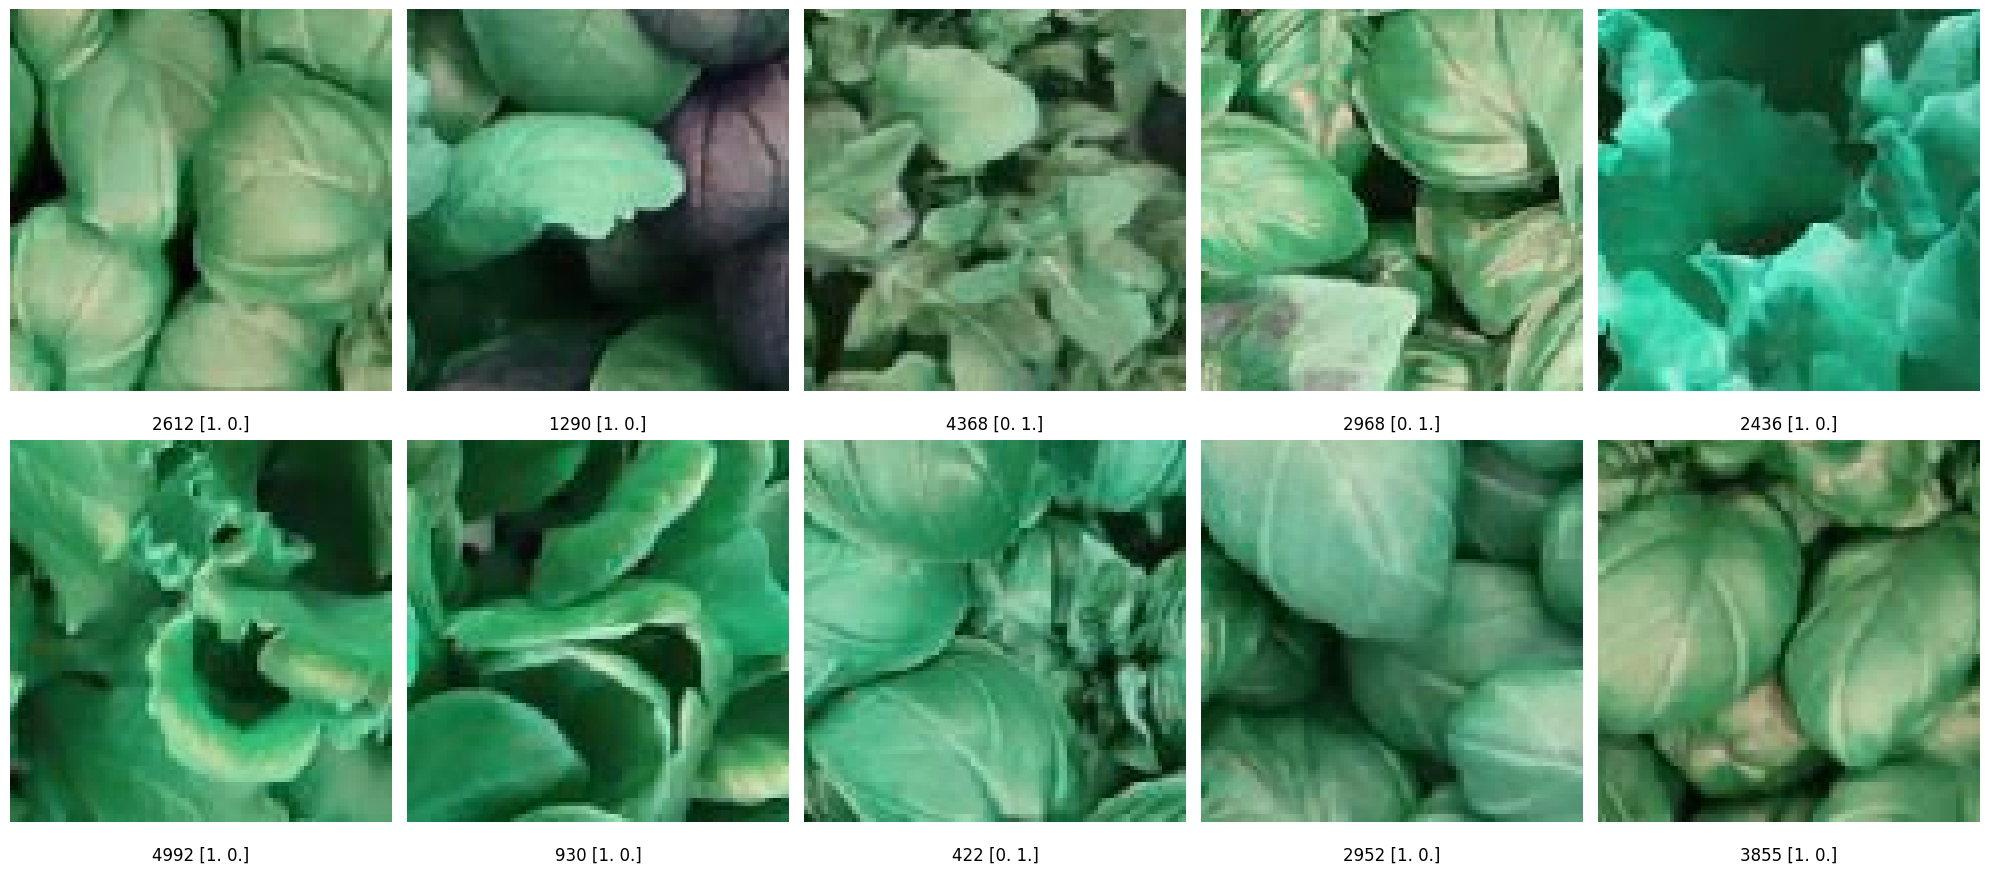

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from data_preparation import load_data, delete_outliers
from data_preparation import display_random_images
import numpy as np
from visualization import plot_history
import pandas as pd

X, y = load_data('/gdrive/MyDrive/Deep Learning Challenge/an2dl_challenge_1/an2dl_challenge_1/public_data.npz')

X, y, num_outliers = delete_outliers(X, y)

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, stratify=np.argmax(y,axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))


display_random_images(X, y, num_img=10)

In [4]:
# Display the count of occurrences of target classes in the training-validation dataset
print('Counting occurrences of target classes:')
print(pd.DataFrame(y_train, columns=['healthy','unhealthy'])['healthy'].value_counts())

Counting occurrences of target classes:
1.0    2511
0.0    1541
Name: healthy, dtype: int64


In [5]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [6]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

80134624/80134624 [==============================] - 0s 0us/step


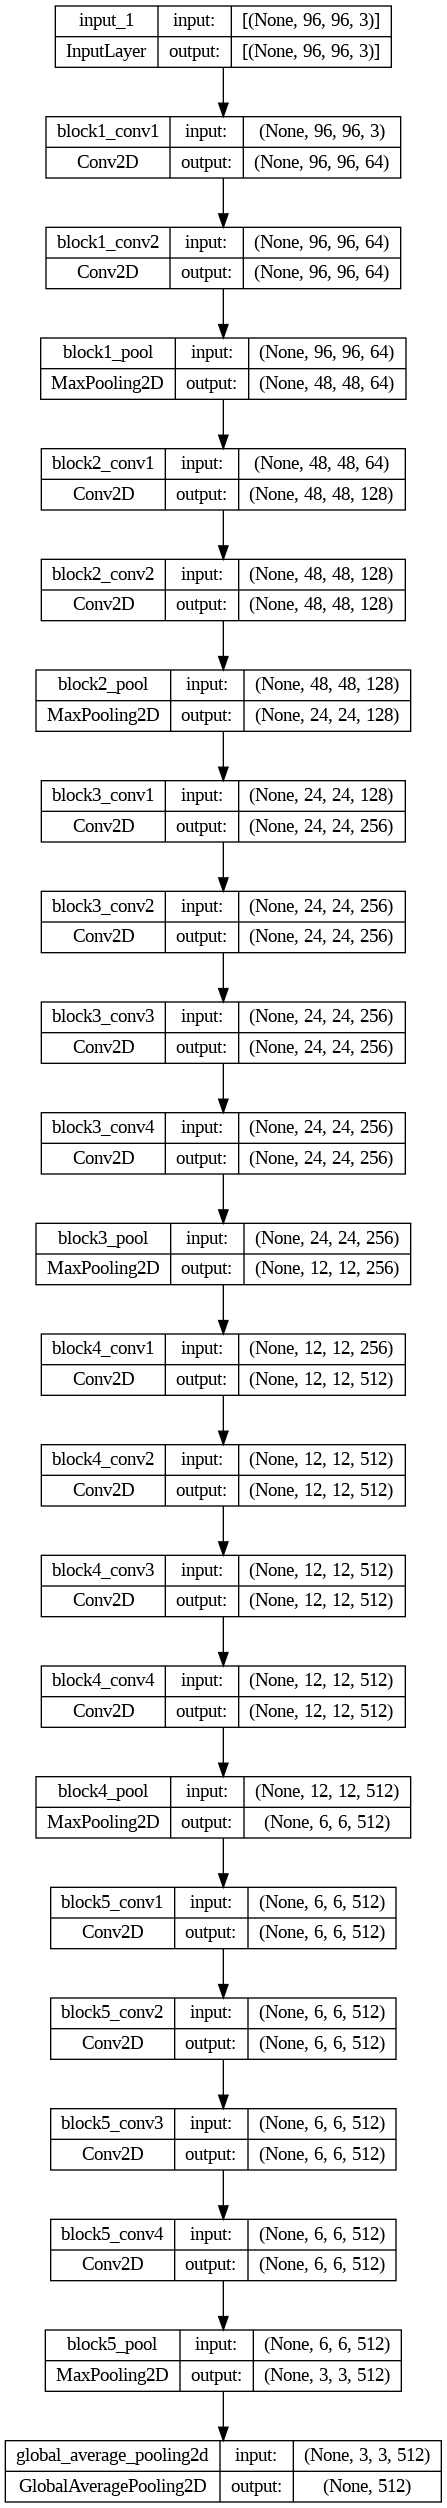

In [7]:
mobile = tfk.applications.VGG19(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
tfk.utils.plot_model(mobile, show_shapes=True)

In [8]:
input_shape = (96, 96, 3)
output_shape = (2)

In [9]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
mobile.trainable = False

# Create an input layer with shape (96, 96, 3)
inputs = tfk.Input(shape=(96, 96, 3))

# Define a preprocessing Sequential model with random flip, zero padding, and random crop
preprocessing = tfk.Sequential([
  tfkl.RandomFlip('horizontal', name='RandomFlip_horizontal'),
  tfkl.ZeroPadding2D((2, 2), name='ZeroPadding_2x2'),
  tfkl.RandomCrop(input_shape[0], input_shape[1], name='RandomCrop')
], name='Preprocessing')

# Apply preprocessing to input layer
x0 = preprocessing(inputs)

# Connect MobileNetV2 to the input
x = mobile(x0)

# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 Preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 20025410 (76.39 MB)
Trainable params: 1026 (4.01 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [10]:
# Train the model
tl_history = tl_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 100,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True)]
).history

Epoch 1/100
254/254 [==============================] - 17s 32ms/step - loss: 0.6040 - accuracy: 0.6777 - val_loss: 0.5787 - val_accuracy: 0.6962
Epoch 2/100
254/254 [==============================] - 6s 25ms/step - loss: 0.5259 - accuracy: 0.7502 - val_loss: 0.5642 - val_accuracy: 0.7361
Epoch 3/100
254/254 [==============================] - 6s 23ms/step - loss: 0.4988 - accuracy: 0.7678 - val_loss: 0.5625 - val_accuracy: 0.7140
Epoch 4/100
254/254 [==============================] - 6s 25ms/step - loss: 0.4823 - accuracy: 0.7725 - val_loss: 0.5502 - val_accuracy: 0.7095
Epoch 5/100
254/254 [==============================] - 6s 24ms/step - loss: 0.4757 - accuracy: 0.7781 - val_loss: 0.5444 - val_accuracy: 0.7361
Epoch 6/100
254/254 [==============================] - 6s 25ms/step - loss: 0.4678 - accuracy: 0.7823 - val_loss: 0.5306 - val_accuracy: 0.7494
Epoch 7/100
254/254 [==============================] - 6s 25ms/step - loss: 0.4641 - accuracy: 0.7757 - val_loss: 0.5234 - val_accuracy

In [11]:
# Save the best model
tl_model.save('TransferLearningModel')
del tl_model

In [12]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TransferLearningModel')
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 Preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 20025410 (76.39 MB)
Trainable params: 1026 (4.01 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [16]:
# Set all MobileNetV2 layers as trainable
ft_model.get_layer('vgg19').trainable = True
for i, layer in enumerate(ft_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
22 global_average_pooling2d True


In [18]:
# Freeze first N layers, e.g., until the 133rd one
N = 15
for i, layer in enumerate(ft_model.get_layer('vgg19').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
22 global_average_pooling2d True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 Preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                 

In [19]:
# Compile the model
ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [20]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 100,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/100
254/254 [==============================] - 19s 43ms/step - loss: 0.4403 - accuracy: 0.7912 - val_loss: 0.4911 - val_accuracy: 0.7672
Epoch 2/100
254/254 [==============================] - 10s 40ms/step - loss: 0.3646 - accuracy: 0.8423 - val_loss: 0.4262 - val_accuracy: 0.7916
Epoch 3/100
254/254 [==============================] - 10s 40ms/step - loss: 0.3082 - accuracy: 0.8685 - val_loss: 0.4423 - val_accuracy: 0.7960
Epoch 4/100
254/254 [==============================] - 10s 40ms/step - loss: 0.2579 - accuracy: 0.8986 - val_loss: 0.4528 - val_accuracy: 0.8160
Epoch 5/100
254/254 [==============================] - 11s 42ms/step - loss: 0.2355 - accuracy: 0.9038 - val_loss: 0.4359 - val_accuracy: 0.8226
Epoch 6/100
254/254 [==============================] - 10s 40ms/step - loss: 0.1822 - accuracy: 0.9289 - val_loss: 0.4731 - val_accuracy: 0.8049
Epoch 7/100
254/254 [==============================] - 10s 40ms/step - loss: 0.1520 - accuracy: 0.9447 - val_loss: 0.5062 - val_ac

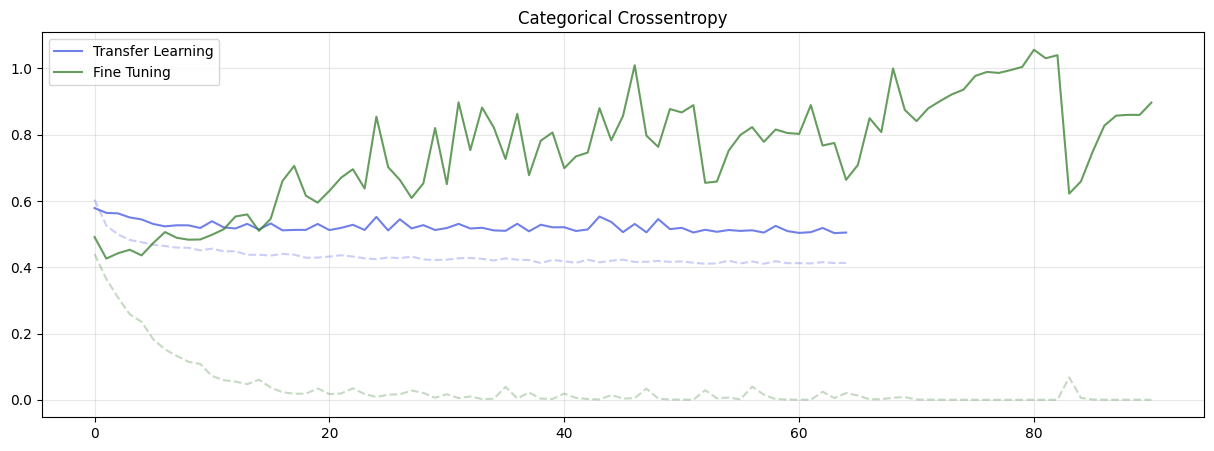

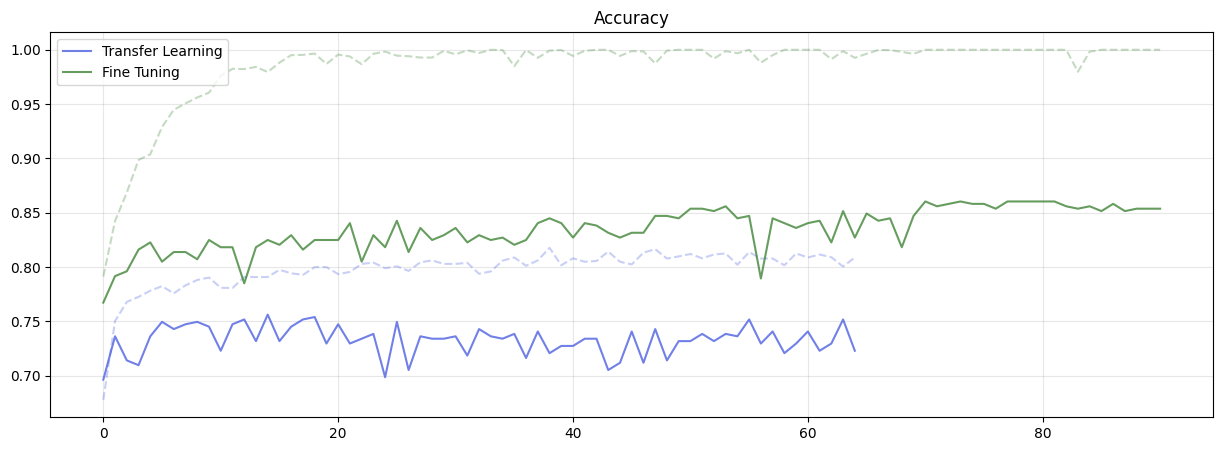

In [21]:
# Plot the transfer learning and the fine-tuned MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [22]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(preprocess_input(X_test*255),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.8902


In [23]:
# Save the best model
ft_model.save('FineTuningModel')
del ft_model

In [24]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('FineTuningModel')
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 Preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 20025410 (76.39 MB)
Trainable params: 11800066 (45.01 MB)
Non-trainable params: 8225344 (31.38 MB)
_________________________________________________________________
